In [7]:
import os
import argparse
import nibabel as nib
import numpy as np
import dipy as dp
print(dp.__version__)
#Pour les stats
import dipy.stats.analysis as dsa
import matplotlib.pyplot as plt
import dipy.tracking.streamline as dts
from scipy import stats
#from dipy.io.streamline import load_tractogram, save_tractogram
#from dipy.io.utils import create_nifti_header,get_reference_info
#from dipy.io import read_bvals_bvecs

from dipy.tracking.utils import density_map
from dipy.tracking.streamline import transform_streamlines

from dipy.segment.mask import median_otsu
from dipy.core.gradients import gradient_table
from dipy.viz import window, actor, ui

#pour calculer la FA
import dipy.reconst.dti as dti
from dipy.reconst.dti import fractional_anisotropy, color_fa

#pour "nettoyer" le bundle
import dipy.tracking.life as life

#pour le clustering de fibres
from dipy.segment.bundles import RecoBundles
from dipy.segment.metric import ResampleFeature
from dipy.segment.metric import AveragePointwiseEuclideanMetric
from dipy.segment.metric import CenterOfMassFeature
from dipy.segment.metric import EuclideanMetric
from dipy.segment.metric import IdentityFeature
from dipy.segment.clustering import QuickBundles

#Pour les stats
import dipy.stats.analysis as dsa
import matplotlib.pyplot as plt
import dipy.tracking.streamline as dts
from scipy import stats

#Pour le reclage de Bundle
from dipy.align.streamlinear import StreamlineLinearRegistration
from dipy.tracking.streamline import transform_streamlines
from dipy.tracking.streamline import set_number_of_points

#Pour calculer la distance entre deux fibres
from scipy.spatial import distance

0.14.0


ImportError: No module named stats.analysis

# Aucun recalage, étude des profiles FA & Density sur le tract post/pre

In [ ]:
MyStreamline=np.array([[74.,56.,60.],[67.,50.,35.],[60.,44.,10.]])
for SESSION in ['dti_pre','dti_post']:
    density_4_all=[]
    fa_4_all=[]
    for SUBJECT in ['sub-PIATBEATRICE','sub-WIBAULTFRANCOIS','sub-BARANATHALIE','sub-DEBERTMARTINE','sub-GUITTONJEAN','sub-BIBIRENE','sub-DEBONNEDANIEL','sub-KUZLAKJAN','sub-BOGENICOLE','sub-DIDIERCLAUDE','sub-MICHOTMICHEL','sub-RIQUEZROBERT','sub-FACQUEANDRE','sub-CARONPAULINE','sub-FIEVETRENE','sub-LEFEBVREGERVAIS','sub-ODOARDJACQUES','sub-CASTORIOMARIO','sub-FUSELIERCHANTAL','sub-LUCASJULES','sub-VANNEAUBERNARD','sub-CLARYSSEJACKY','sub-GALLANTMARIELAURE','sub-RICHERATEAUXFLORENCE']: 
    #for SUBJECT in ['sub-PIATBEATRICE']: 
        print(SUBJECT)
        FS_PATH='''/NAS/dumbo/protocoles/Thalamotomy/BIDS_PROCESS/freesurfer/'''
        TCK_LOCATION=FS_PATH+SUBJECT+'/'+SESSION+'/'
        STR_FX='''VLP_L_brain_bin_roi_Cereb_WM_R.nii_6_50000'''
        FBVAL = TCK_LOCATION+"dti.bval"
        FBVEC = TCK_LOCATION+"dti.bvec"

        renderer = window.Renderer()
        world_coords=False

        #Chargement tck/b0/DTI
        reference_anatomy = nib.load(TCK_LOCATION+"b0.nii.gz")
        reference_anatomy_data = reference_anatomy.get_data()

        affine, dimensions, voxel_sizes, voxel_order = get_reference_info(reference_anatomy)

        img=nib.load(TCK_LOCATION+"dti.nii.gz")
        data = img.get_data()

        cc_sft = load_tractogram(TCK_LOCATION+STR_FX+".tck", reference_anatomy)
        streamlines=cc_sft.streamlines
        if not world_coords:
            streamlines = transform_streamlines(streamlines, np.linalg.inv(reference_anatomy.affine))
        print("data loaded")

        #Nettoyage du bundle
        img=nib.load(TCK_LOCATION+"dti.nii.gz")
        data = img.get_data()
        bvals, bvecs = read_bvals_bvecs(FBVAL,FBVEC)
        gtab = gradient_table(bvals,bvecs)
        fiber_model = life.FiberModel(gtab)
        fiber_fit = fiber_model.fit(data, streamlines, affine=np.eye(4))
        streamlines = streamlines[np.where(fiber_fit.beta == 0)[0]]
        print("Bundle cleaned")
        cc_sft.to_vox()

        ## Density map
        density = density_map(streamlines, np.eye(4), dimensions)
        ## FA
        tenmodel = dti.TensorModel(gtab)
        tenfit = tenmodel.fit(data)
        FA = fractional_anisotropy(tenfit.evals)
        FA[np.isnan(FA)] = 0
        print("density and FA computed")

        #Clustering
        #feature = ResampleFeature(nb_points=100)
        #metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
        #qb = QuickBundles(threshold=10,metric=metric)
        #qb.max_nb_clusters = 1
        #cluster = qb.cluster(streamlines)
        #stream_actor = actor.line(cluster.centroids,density/np.max(density),linewidth=5,opacity=1)
        #renderer.add(stream_actor)
        #print("Cluster computed")

        #Calcul des profil
        streamlines = dts.orient_by_streamline(streamlines,MyStreamline)
        w_af_l = dsa.gaussian_weights(streamlines)
        profile_density = dsa.afq_profile(density, streamlines,np.eye(4),weights=w_af_l)
        density_4_all.append(profile_density)
        profile_fa = dsa.afq_profile(FA, streamlines,np.eye(4),weights=w_af_l)
        fa_4_all.append(profile_fa)
        print("Profiles computed")

        #stream_actor = actor.line(streamlines,density/np.max(density),linewidth=0.1,opacity=0.5)
        #renderer.add(stream_actor)

        #ajouter l'affichage du target ICI
        #renderer.set_camera(position=(145.23, 132.71, -9.62),
        #                    focal_point=(64.54, 59.89, 24.14),
        #                    view_up=(0.08, 0.35, 0.93))

        #window.record(renderer, out_path=TCK_LOCATION+"bundleView.nii.gz", size=(600, 600))
        #window.show(renderer, size=(600, 600), reset_camera=False)

    np.savetxt('/NAS/dumbo/protocoles/Thalamotomy/fa'+SESSION+'_4_R_new.csv',fa_4_all, delimiter=',') 
    np.savetxt('/NAS/dumbo/protocoles/Thalamotomy/density'+SESSION+'_4_R_new.csv',density_4_all, delimiter=',') 
    
#print(len(density_4_all))
#print(len(fa_4_all))

In [53]:
feature = ResampleFeature(nb_points=100)
metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
qb = QuickBundles(threshold=10,metric=metric)
qb.max_nb_clusters = 1
cluster = qb.cluster(streamlines)
stream_actor = actor.line(cluster.centroids,density/np.max(density),linewidth=5,opacity=1)
renderer.add(stream_actor)
print("Cluster computed")

Cluster computed


In [177]:
print(TCK_LOCATION+STR_FX+".tck")

/NAS/dumbo/protocoles/Thalamotomy/BIDS_PROCESS/freesurfer/sub-RICHERATEAUXFLORENCE/dti_post/VLP_L_brain_bin_roi_Cereb_WM_R.nii_6_50000.tck


In [ ]:
##affichage du target 
imgTarget=nib.load(TCK_LOCATION+"target.nii.gz")
mask = imgTarget.get_data()
if not world_coords:
    vol_actor = actor.slicer(mask,affine=np.eye(4),opacity=0.5)
else:
    vol_actor = actor.slicer(mask,imgTarget.affine,opacity=0.5)
vol_actor.display(z=30)
#renderer.add(vol_actor)

target = mask == 1
seedroi_actor = actor.contour_from_roi(target,np.eye(4),[1, 0, 0], 1)
renderer.add(seedroi_actor)

if not world_coords:
    vol_actor = actor.slicer(reference_anatomy_data,affine=np.eye(4),opacity=0.5)
else:
    vol_actor = actor.slicer(reference_anatomy_data,reference_anatomy.affine,opacity=0.5)
vol_actor.display(x=60)
renderer.add(vol_actor)

Affichage des courbes ggplot

In [40]:
from ggplot import *

In [39]:
print(range(100))
#ggplot(range(100),fa_pre_4_R[1,:]) #+ geom_line()
#+ gg.geom_smooth(color="blue")

range(0, 100)


In [9]:
import os
import argparse
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import dipy.tracking.streamline as dts
from scipy import stats

fa_pre_4_R=np.loadtxt('''/NAS/dumbo/protocoles/Thalamotomy/fa_dti_pre_4_R_new.csv''', delimiter=',')
density_pre_4_R=np.loadtxt('''/NAS/dumbo/protocoles/Thalamotomy/density_dti_pre_4_R_new.csv''', delimiter=',')
fa_post_4_R=np.loadtxt('''/NAS/dumbo/protocoles/Thalamotomy/fa_dti_post_4_R_new.csv''', delimiter=',')
density_post_4_R=np.loadtxt('''/NAS/dumbo/protocoles/Thalamotomy/density_dti_post_4_R_new.csv''', delimiter=',')

density_post_4_G1_R=density_post_4_R[[0,1,2,3,4,5,6,7,8,9,10,13,16,17,18,22],:]
density_post_4_G2_R=density_post_4_R[[11,12,14,15,19,20,21,23],:]
density_pre_4_G1_R=density_pre_4_R[[0,1,2,3,4,5,6,7,8,9,10,13,16,17,18,22],:]
density_pre_4_G2_R=density_pre_4_R[[11,12,14,15,19,20,21,23],:]

fa_post_4_G1_R=fa_post_4_R[[0,1,2,3,4,5,6,7,8,9,10,13,16,17,18,22],:]
fa_post_4_G2_R=fa_post_4_R[[11,12,14,15,19,20,21,23],:]
fa_pre_4_G1_R=fa_pre_4_R[[0,1,2,3,4,5,6,7,8,9,10,13,16,17,18,22],:]
fa_pre_4_G2_R=fa_pre_4_R[[11,12,14,15,19,20,21,23],:]

densité post amélioré / non amélioré : density_post
[0.039, 0.038, 0.04, 0.043, 0.044, 0.046, 0.047, 0.049, 0, 0, 0, 0, 0, 0, 0.046, 0.046, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.031, 0.027, 0.023, 0.02, 0.017, 0.013, 0.011, 0.007, 0.005, 0.004, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.017, 0.018, 0.02, 0.02, 0.02, 0.02, 0.018, 0.017, 0.016, 0.003, 0.003, 0.004, 0.004, 0.006, 0.006, 0.009, 0.013, 0.017, 0.015, 0.017, 0.017, 0.02, 0.023, 0.031, 0.031, 0.031]


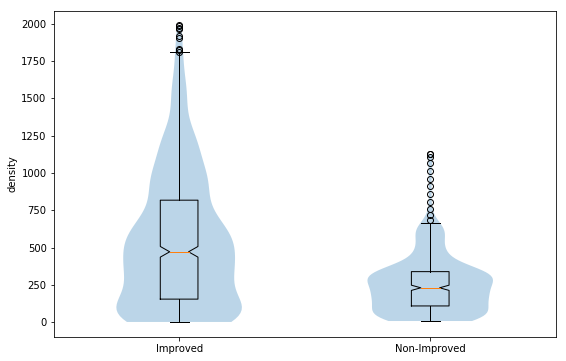

fa post amélioré / non amélioré : fa_post
[0, 0, 0, 0.032, 0.02, 0.015, 0.013, 0.012, 0.016, 0.027, 0.044, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


NameError: name 'fa_pre' is not defined

In [3]:


#t2, p2 = stats.mannwhitneyu(fa_post_4_G1_R,fa_post_4_G2_R)
#p2_th=np.where(p2<0.05,p2,0)
#if (np.min(p2) < 0.05):
#    print(p2_th)

print("densité post amélioré / non amélioré : density_post")
density_post=[]
for i in range(100) :
    a1,b1=stats.shapiro(density_post_4_G1_R[:,i])
    a2,b2=stats.shapiro(density_post_4_G2_R[:,i])
    if (b1>0.05 and b2>0.05) :
        t2, p2 = stats.ttest_ind(density_post_4_G1_R[:,i],density_post_4_G2_R[:,i])
    else :
        t2, p2 = stats.mannwhitneyu(density_post_4_G1_R[:,i],density_post_4_G2_R[:,i])    
    if p2<0.05 :
        density_post.append(np.round(p2,3))
    else :
        density_post.append(0)
print(density_post)
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.boxplot([density_post_4_G1_R[:,np.where(np.asarray(density_post)>0)].flatten(),density_post_4_G2_R[:,np.where(np.asarray(density_post)>0)].flatten()],["G1","G2"])
ax.set_ylabel("density")
ax.set_xticklabels(['Improved','Non-Improved'])
#legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.violinplot([density_post_4_G1_R[:,np.where(np.asarray(density_post)>0)].flatten(),density_post_4_G2_R[:,np.where(np.asarray(density_post)>0)].flatten()],showextrema=False)
plt.savefig('/NAS/dumbo/protocoles/Thalamotomy/density_post.png')
plt.show()

print("fa post amélioré / non amélioré : fa_post")
fa_post=[]
for i in range(100) :
    a1,b1=stats.shapiro(fa_post_4_G1_R[:,i])
    a2,b2=stats.shapiro(fa_post_4_G2_R[:,i])
    if (b1>0.05 and b2>0.05) :
        t2, p2 = stats.ttest_ind(fa_post_4_G1_R[:,i],fa_post_4_G2_R[:,i])
    else :
        t2, p2 = stats.mannwhitneyu(fa_post_4_G1_R[:,i],fa_post_4_G2_R[:,i])    
    if p2<0.05 :
        fa_post.append(np.round(p2,3))
    else :
        fa_post.append(0)
print(fa_post)
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.boxplot([fa_post_4_G1_R[:,np.where(np.asarray(fa_post)>0)].flatten(),fa_post_4_G2_R[:,np.where(np.asarray(fa_post)>0)].flatten()],["G1","G2"])
ax.set_ylabel("FA post")
ax.set_xticklabels(['Improved','Non-Improved'])
#legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.violinplot([fa_post_4_G1_R[:,np.where(np.asarray(fa_pre)>0)].flatten(),fa_post_4_G2_R[:,np.where(np.asarray(fa_pre)>0)].flatten()],showextrema=False)
plt.savefig('/NAS/dumbo/protocoles/Thalamotomy/fa_post.png')
plt.show()

print("densité pré amélioré / non amélioré : density_pre")
density_pre=[]
for i in range(100) :
    a1,b1=stats.shapiro(density_pre_4_G1_R[:,i])
    a2,b2=stats.shapiro(density_pre_4_G2_R[:,i])
    if (b1>0.05 and b2>0.05) :
        t2, p2 = stats.ttest_ind(density_pre_4_G1_R[:,i],density_pre_4_G2_R[:,i])
    else :
        t2, p2 = stats.mannwhitneyu(density_pre_4_G1_R[:,i],density_pre_4_G2_R[:,i])    
    if p2<0.05 :
        density_pre.append(np.round(p2,3))
    else :
        density_pre.append(0)
print(density_pre)

print("fa pré amélioré / non amélioré : fa_pre")
fa_pre=[]
for i in range(100) :
    a1,b1=stats.shapiro(fa_pre_4_G1_R[:,i])
    a2,b2=stats.shapiro(fa_pre_4_G2_R[:,i])
    if (b1>0.05 and b2>0.05) :
        t2, p2 = stats.ttest_ind(fa_pre_4_G1_R[:,i],fa_pre_4_G2_R[:,i])
    else :
        t2, p2 = stats.mannwhitneyu(fa_pre_4_G1_R[:,i],fa_pre_4_G2_R[:,i])    
    if p2<0.05 :
        fa_pre.append(np.round(p2,3))
    else :
        fa_pre.append(0)
print(fa_pre)
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.boxplot([fa_pre_4_G1_R[:,np.where(np.asarray(fa_pre)>0)].flatten(),fa_pre_4_G2_R[:,np.where(np.asarray(fa_pre)>0)].flatten()],["G1","G2"])
ax.set_ylabel("FA pre")
ax.set_xticklabels(['Improved','Non-Improved'])
#legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.violinplot([fa_pre_4_G1_R[:,np.where(np.asarray(fa_pre)>0)].flatten(),fa_pre_4_G2_R[:,np.where(np.asarray(fa_pre)>0)].flatten()],showextrema=False)
plt.savefig('/NAS/dumbo/protocoles/Thalamotomy/fa_pre.png')
plt.show()
        
print("densité pré/post : density_pre_post")
density_pre_post=[]
for i in range(100) :
    a1,b1=stats.shapiro(density_post_4_R[:,i])
    a2,b2=stats.shapiro(density_pre_4_R[:,i])
    if (b1>0.05 and b2>0.05) :
        t2, p2 = stats.ttest_rel(density_post_4_R[:,i],density_pre_4_R[:,i])
    else :
        t2, p2 = stats.wilcoxon(density_post_4_R[:,i],density_pre_4_R[:,i])    
    if p2<0.05 :
        density_pre_post.append(np.round(p2,3))
    else :
        density_pre_post.append(0)
print(density_pre_post)
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.boxplot([density_pre_4_R[:,np.where(np.asarray(density_pre_post)>0)].flatten(),\
            density_post_4_R[:,np.where(np.asarray(density_pre_post)>0)].flatten()],["G1","G2"])
ax.set_ylabel("Densité")
ax.set_xticklabels(['Pre','Post'])
#legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.violinplot([density_pre_4_R[:,np.where(np.asarray(density_pre_post)>0)].flatten(),\
                density_post_4_R[:,np.where(np.asarray(density_pre_post)>0)].flatten()],showextrema=False)
plt.savefig('/NAS/dumbo/protocoles/Thalamotomy/density_pre_post.png')
plt.show()
                     
print("fa pré/post : fa_pre_post")
fa_pre_post=[]
for i in range(100) :
    a1,b1=stats.shapiro(fa_post_4_R[:,i])
    a2,b2=stats.shapiro(fa_pre_4_R[:,i])
    if (b1>0.05 and b2>0.05) :
        t2, p2 = stats.ttest_rel(fa_post_4_R[:,i],fa_pre_4_R[:,i])
    else :
        t2, p2 = stats.wilcoxon(fa_post_4_R[:,i],fa_pre_4_R[:,i])    
    if p2<0.05 :
        fa_pre_post.append(np.round(p2,3))
    else :
        fa_pre_post.append(0)
print(fa_pre_post)
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.boxplot([fa_pre_4_R[:,np.where(np.asarray(fa_pre_post)>0)].flatten(),fa_post_4_R[:,np.where(np.asarray(fa_pre_post)>0)].flatten()],["G1","G2"])
ax.set_ylabel("FA")
ax.set_xticklabels(['pre','post'])
#legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.violinplot([fa_pre_4_R[:,np.where(np.asarray(fa_pre_post)>0)].flatten(),fa_post_4_R[:,np.where(np.asarray(fa_pre_post)>0)].flatten()],showextrema=False)
plt.savefig('/NAS/dumbo/protocoles/Thalamotomy/fa_pre_post.png')
plt.show()

print("fa post-pré amélioré / non amélioré : diff_fa_G1_G2")
diff_fa_G1_G2=[]
diff_fa_G1=fa_post_4_G1_R-fa_pre_4_G1_R
diff_fa_G2=fa_post_4_G2_R-fa_pre_4_G2_R
for i in range(100) :
    a1,b1=stats.shapiro(diff_fa_G1[:,i])
    a2,b2=stats.shapiro(diff_fa_G2[:,i])
    if (b1>0.05 and b2>0.05) :
        t2, p2 = stats.ttest_ind(diff_fa_G1[:,i],diff_fa_G2[:,i])
    else :
        t2, p2 = stats.mannwhitneyu(diff_fa_G1[:,i],diff_fa_G2[:,i])    
    if p2<0.05 :
        diff_fa_G1_G2.append(np.round(p2,3))
    else :
        diff_fa_G1_G2.append(0)    
print(diff_fa_G1_G2)
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.boxplot([diff_fa_G1[:,np.where(np.asarray(diff_fa_G1_G2)>0)].flatten(),diff_fa_G2[:,np.where(np.asarray(diff_fa_G1_G2)>0)].flatten()],["G1","G2"])
ax.set_ylabel("FA difference (post-pre)")
ax.set_xticklabels(['Improved','Non-improved'])
#legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.violinplot([diff_fa_G1[:,np.where(np.asarray(diff_fa_G1_G2)>0)].flatten(),diff_fa_G2[:,np.where(np.asarray(diff_fa_G1_G2)>0)].flatten()],showextrema=False)
plt.savefig('/NAS/dumbo/protocoles/Thalamotomy/diff_fa_G1_G2.png')
plt.show()

print("densité post-pré amélioré / non amélioré : diff_density_G1_G2")
diff_density_G1_G2=[]
diff_density_G1=density_post_4_G1_R-density_pre_4_G1_R
diff_density_G2=density_post_4_G2_R-density_pre_4_G2_R
for i in range(100) :
    a1,b1=stats.shapiro(diff_density_G1[:,i])
    a2,b2=stats.shapiro(diff_density_G2[:,i])
    if (b1>0.05 and b2>0.05) :
        t2, p2 = stats.ttest_ind(diff_density_G1[:,i],diff_density_G2[:,i])
    else :
        t2, p2 = stats.mannwhitneyu(diff_density_G1[:,i],diff_density_G2[:,i])    
    if p2<0.05 :
        diff_density_G1_G2.append(np.round(p2,3))
    else :
        diff_density_G1_G2.append(0) 
print(diff_density_G1_G2)
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.boxplot([diff_density_G1[:,np.where(np.asarray(diff_density_G1_G2)>0)].flatten(),diff_density_G2[:,np.where(np.asarray(diff_density_G1_G2)>0)].flatten()],["G1","G2"])
ax.set_ylabel("Density difference (post-pre)")
ax.set_xticklabels(['Improved','Non-improved'])
#legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.violinplot([diff_density_G1[:,np.where(np.asarray(diff_density_G1_G2)>0)].flatten(),diff_density_G2[:,np.where(np.asarray(diff_density_G1_G2)>0)].flatten()],showextrema=False)
plt.savefig('/NAS/dumbo/protocoles/Thalamotomy/diff_density_G1_G2.png')
plt.show()

Pour corriger avec FDR directement en notebook

In [13]:
import statsmodels.api as sm
#sm.stats.multitest.multipletests(P2, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)
sm.stats.fdrcorrection(density_post,alpha=0.05,method='indep',is_sorted=False)

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([0.04285714, 0.04222222, 0.04301075, 0.04574468, 0.04631579,
        0.04693878, 0.04747475, 0.049     , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.04693878

In [158]:
print("densité post amélioré / non amélioré : density_post")
print(density_post)

print("fa post amélioré / non amélioré : fa_post")
print(fa_post)

print("densité pré amélioré / non amélioré : density_pre")
print(density_pre)

print("fa pré amélioré / non amélioré : fa_pre")
print(fa_pre)
        
print("densité pré/post : density_pre_post")
print(density_pre_post)
                
print("fa pré/post : fa_pre_post")
print(fa_pre_post)

print("fa post-pré amélioré / non amélioré : diff_fa_G1_G2")   
print(diff_fa_G1_G2)

print("densité post-pré amélioré / non amélioré : diff_density_G1_G2") 
print(diff_density_G1_G2)

densité post amélioré / non amélioré : density_post
[0.039, 0.038, 0.04, 0.043, 0.044, 0.046, 0.047, 0.049, 0, 0, 0, 0, 0, 0, 0.046, 0.046, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.031, 0.027, 0.023, 0.02, 0.017, 0.013, 0.011, 0.007, 0.005, 0.004, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.017, 0.018, 0.02, 0.02, 0.02, 0.02, 0.018, 0.017, 0.016, 0.003, 0.003, 0.004, 0.004, 0.006, 0.006, 0.009, 0.013, 0.017, 0.015, 0.017, 0.017, 0.02, 0.023, 0.031, 0.031, 0.031]
fa post amélioré / non amélioré : fa_post
[0, 0, 0, 0.032, 0.02, 0.015, 0.013, 0.012, 0.016, 0.027, 0.044, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
densité pré amélioré / non amélioré : density_pre
[0, 0, 0, 0, 0, 0, 

In [178]:
renderer = window.Renderer()

#stream_actor = actor.line(cc_sft_native[:],window.colors.blue,linewidth=1)
#stream_actor = actor.line(optimized_sl[:],FA,linewidth=1)
stream_actor = actor.line(streamlines,window.colors.white,linewidth=0.1,opacity=0.3)
#renderer.add(stream_actor)

hue = (0.0,0.0)  # red density_post.jpg
saturation = (0.0, 1.0)  
lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)
#bar2 = actor.scalar_bar(lut_cmap)
#renderer.add(bar2)

logp=-1*np.log10(density_post)
logp_th=np.where(logp<1000,logp,0)

lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)
stream_actor = actor.line(cluster.centroids,logp_th,linewidth=5,lookup_colormap=lut_cmap,opacity=1)
#stream_actor = actor.line(optimized_sl[100:1000],density/np.max(density),linewidth=0.1,opacity=0.5)
#stream_actor = actor.line(cc_sft_native[0:100],FA,linewidth=0.1,lookup_colormap=lut_cmap)
#renderer.add(stream_actor)

hue = (0.166,0.166)  # yellow diff_density_G1_G2.jpg
saturation = (0.0, 1.0) 
lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)
logp=-1*np.log10(diff_density_G1_G2)
logp_th=np.where(logp<1000,logp,0)
stream_actor = actor.line(cluster.centroids,logp_th,linewidth=5,lookup_colormap=lut_cmap,opacity=1)
#renderer.add(stream_actor)

hue = (0.3333,0.3333)  # Green diff_fa_G1_G2.jpg
saturation = (0.0, 1.0)  
lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)
logp=-1*np.log10(diff_fa_G1_G2)
logp_th=np.where(logp<1000,logp,0)
stream_actor = actor.line(cluster.centroids,logp_th,linewidth=5,lookup_colormap=lut_cmap,opacity=1)
#renderer.add(stream_actor)

hue = (0.6666,0.6666)  # Blue fa_pre.jpg
saturation = (0.0, 1.0)  
lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)
logp=-1*np.log10(fa_pre)
logp_th=np.where(logp<1000,logp,0)
stream_actor = actor.line(cluster.centroids,logp_th,linewidth=5,lookup_colormap=lut_cmap,opacity=1)
renderer.add(stream_actor)

hue = (0.83333,0.83333)  # Pink fa_pre_post.jpg
saturation = (0.0, 1.0)  
lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)
logp=-1*np.log10(fa_pre_post)
logp_th=np.where(logp<1000,logp,0)
stream_actor = actor.line(cluster.centroids,logp_th,linewidth=5,lookup_colormap=lut_cmap,opacity=1)
#renderer.add(stream_actor)

ima_t1 = nib.load(TCK_LOCATION+"rt1_dti_ras.nii.gz")
ima_t1_data = ima_t1.get_data()
vol_actor = actor.slicer(ima_t1_data)
vol_actor.opacity(1)
vol_actor.display(x=60)
renderer.add(vol_actor)

vol_actor = actor.slicer(ima_t1_data)
vol_actor.display(y=80)
vol_actor.opacity(1)
renderer.add(vol_actor)

vol_actor = actor.slicer(ima_t1_data)
vol_actor.display(z=25)
vol_actor.opacity(1)
renderer.add(vol_actor)

##affichage du target 

imgTarget=nib.load(TCK_LOCATION+"target.nii.gz")
mask = imgTarget.get_data()
if not world_coords:
    vol_actor = actor.slicer(mask,affine=np.eye(4),opacity=0.5)
else:
    vol_actor = actor.slicer(mask,imgTarget.affine,opacity=0.5)
vol_actor.display(z=30)
#renderer.add(vol_actor)

target = mask == 1
seedroi_actor = actor.contour_from_roi(target,np.eye(4),[1, 0, 0], 1)
renderer.add(seedroi_actor)

if not world_coords:
    vol_actor = actor.slicer(reference_anatomy_data,affine=np.eye(4),opacity=0.5)
else:
    vol_actor = actor.slicer(reference_anatomy_data,reference_anatomy.affine,opacity=0.5)
vol_actor.display(x=60)
renderer.add(vol_actor)

renderer.set_camera(position=(221.72, -1.10, 53.08),
                    focal_point=(63.50, 63.50, 32.50),
                    view_up=(-0.16, -0.07, 0.99))

#window.record(renderer, out_path='/NAS/dumbo/protocoles/Thalamotomy/3DView_fa_pre_post.png', size=(1200,1200))
window.show(renderer, size=(600, 600), reset_camera=False)
#renderer.camera_info()

/home/global/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/home/global/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log10
/home/global/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in log10
/home/global/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log10
/home/global/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in log10


In [55]:
renderer = window.Renderer()

stream_actor = actor.line(streamlines,window.colors.white,linewidth=0.1,opacity=0.3)
renderer.add(stream_actor)

a=np.add(density_post, diff_density_G1_G2) 
b=np.add(diff_fa_G1_G2, fa_pre) 
c=np.add(fa_pre_post, a)
d=np.add(c, b)

hue = (0.0,0.0)  # red density_post.jpg
saturation = (0.0, 1.0)  
lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)
logp=-1*np.log10(d)
logp_th=np.where(logp<1000,logp,0)
lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)
stream_actor = actor.line(cluster.centroids,logp_th,linewidth=5,lookup_colormap=lut_cmap,opacity=0.9)
renderer.add(stream_actor)

ima_t1 = nib.load(TCK_LOCATION+"rt1_dti_ras.nii.gz")
ima_t1_data = ima_t1.get_data()
vol_actor = actor.slicer(ima_t1_data)
vol_actor.opacity(0.6)
vol_actor.display(x=60)
renderer.add(vol_actor)

vol_actor = actor.slicer(ima_t1_data)
vol_actor.display(y=40)
vol_actor.opacity(0.6)
renderer.add(vol_actor)

renderer.set_camera(position=(158.68, -54.43, 26.98),
                    focal_point=(61.71, 49.73, 31.36),
                    view_up=(0.01, -0.03, 1.00))

window.record(renderer, out_path='/NAS/dumbo/protocoles/Thalamotomy/3DView.png', size=(1200,1200))
window.show(renderer, size=(600, 600), reset_camera=False)

/home/global/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


In [1]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.plot(np.median(np.transpose(fa_pre_4_G1_R),axis=1),color='blue',label="Improved Pre")
ax.plot(np.median(np.transpose(fa_pre_4_G2_R),axis=1),color='red',label="Non-Improved Pre")
ax.plot(np.median(np.transpose(fa_post_4_G1_R),axis=1),color='black',label="Improved Post")
ax.plot(np.median(np.transpose(fa_post_4_G2_R),axis=1),color='pink',label="Non-Improved Post")
ax.set_ylabel("FA")
ax.set_xlabel("Node along bundle")
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.show()

NameError: name 'plt' is not defined

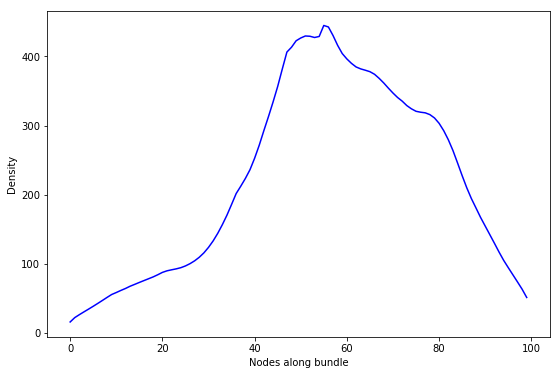

In [14]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.plot(np.median(np.transpose(density_pre_4_G1_R),axis=1),color='blue')
#ax.plot(np.median(np.transpose(density_pre_4_G1_R),axis=1),color='blue',label="Improved Pre")
#ax.plot(np.median(np.transpose(density_pre_4_G2_R),axis=1),color='red',label="Non-Improved Pre")
#ax.plot(np.median(np.transpose(density_post_4_G1_R),axis=1),color='black',label="Improved Post")
#ax.plot(np.median(np.transpose(density_post_4_G2_R),axis=1),color='pink',label="Non-Improved Post")
ax.set_ylabel("Density")
ax.set_xlabel("Nodes along bundle")
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.savefig('profile.png')
plt.show()

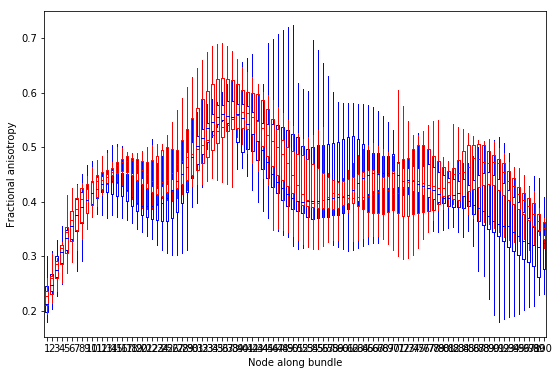

In [138]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(fa_pre_4_G1_R,meanline=True,showmeans=False,showfliers=False,showcaps=False)
ax.set_ylabel("Fractional anisotropy")
ax.set_xlabel("Node along bundle")
for _, line_list in bp.items():
    for line in line_list:
        line.set_color('b')
        
bp = ax.boxplot(fa_pre_4_G2_R,meanline=True,showmeans=False,showfliers=False,showcaps=False)
ax.set_ylabel("Fractional anisotropy")
ax.set_xlabel("Node along bundle")
for _, line_list in bp.items():
    for line in line_list:
        line.set_color('r')        
        
        
plt.show()

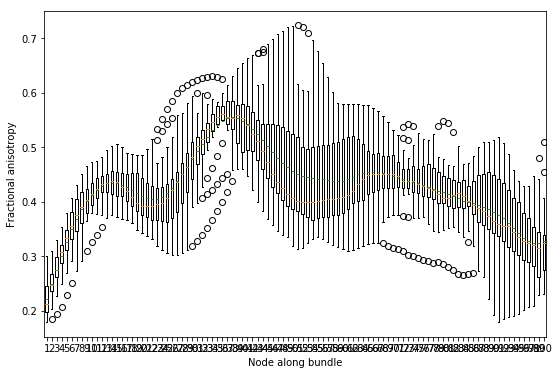

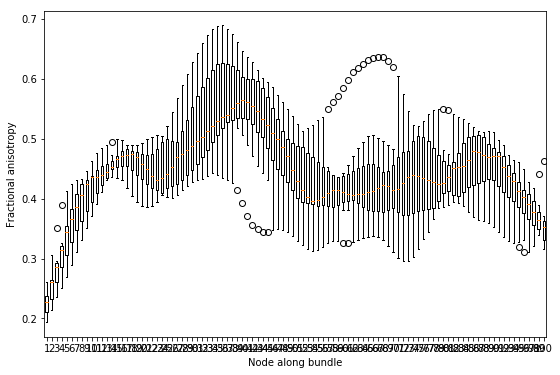

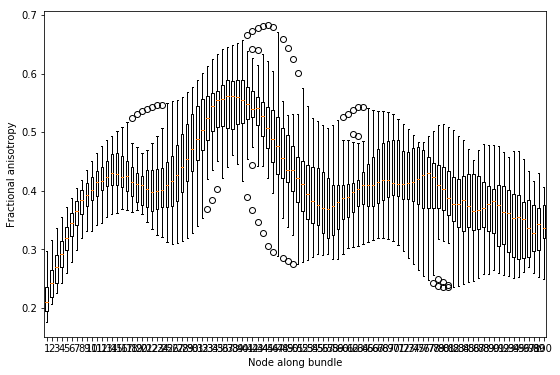

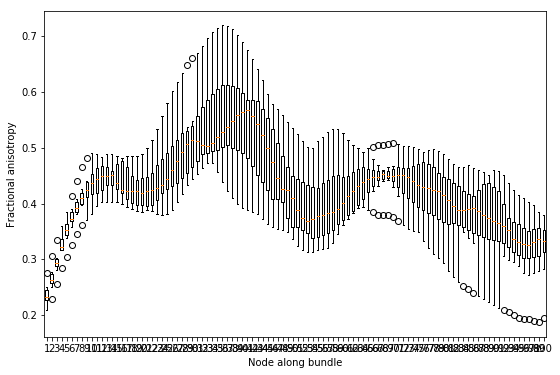

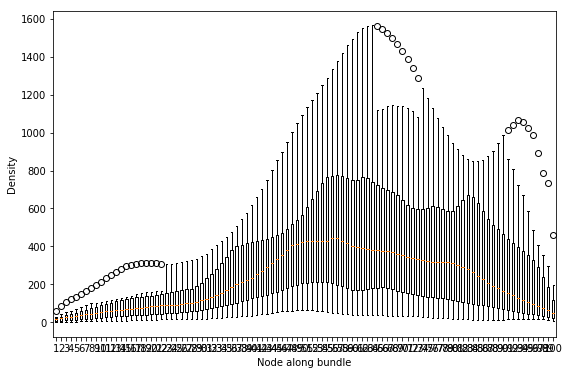

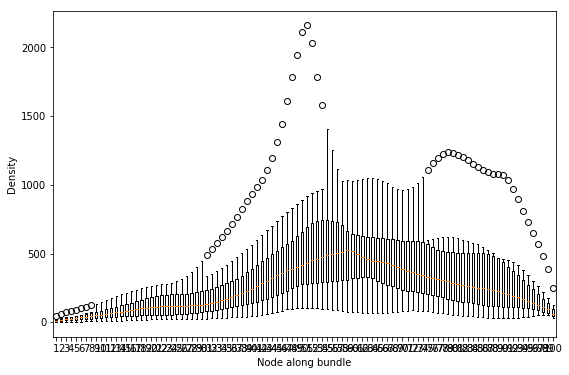

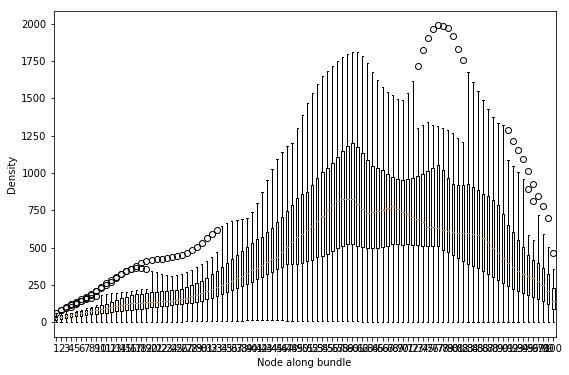

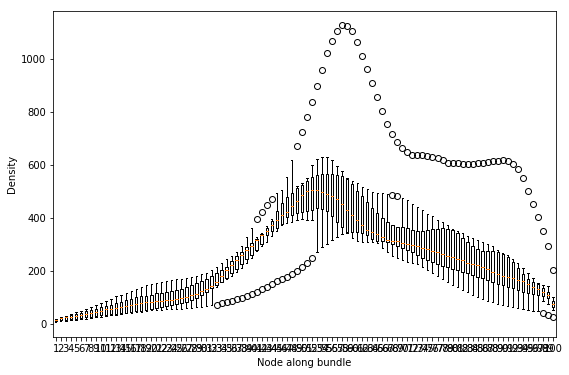

In [128]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(fa_pre_4_G1_R,meanline=True,showmeans=True)
ax.set_ylabel("Fractional anisotropy")
ax.set_xlabel("Node along bundle")
plt.show()

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(fa_pre_4_G2_R)
ax.set_ylabel("Fractional anisotropy")
ax.set_xlabel("Node along bundle")
plt.show()

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(fa_post_4_G1_R)
ax.set_ylabel("Fractional anisotropy")
ax.set_xlabel("Node along bundle")
plt.show()

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(fa_post_4_G2_R)
ax.set_ylabel("Fractional anisotropy")
ax.set_xlabel("Node along bundle")
plt.show()


fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(density_pre_4_G1_R)
ax.set_ylabel("Density")
ax.set_xlabel("Node along bundle")
plt.show()

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(density_pre_4_G2_R)
ax.set_ylabel("Density")
ax.set_xlabel("Node along bundle")
plt.show()

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(density_post_4_G1_R)
ax.set_ylabel("Density")
ax.set_xlabel("Node along bundle")
plt.show()

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(density_post_4_G2_R)
ax.set_ylabel("Density")
ax.set_xlabel("Node along bundle")
plt.show()

In [117]:
fa_pre_4_G1_R[::,::5].shape

(16, 20)

In [100]:
renderer = window.Renderer()
srr = StreamlineLinearRegistration()
FirstTrak=True
#'sub-PIATBEATRICE','sub-WIBAULTFRANCOIS','sub-BARANATHALIE','sub-DEBERTMARTINE','sub-GUITTONJEAN','sub-BIBIRENE','sub-DEBONNEDANIEL','sub-KUZLAKJAN','sub-BOGENICOLE','sub-DIDIERCLAUDE','sub-MICHOTMICHEL','sub-RIQUEZROBERT','sub-FACQUEANDRE','sub-CARONPAULINE','sub-FIEVETRENE','sub-LEFEBVREGERVAIS','sub-ODOARDJACQUES','sub-CASTORIOMARIO','sub-FUSELIERCHANTAL','sub-LUCASJULES','sub-VANNEAUBERNARD','sub-CLARYSSEJACKY','sub-GALLANTMARIELAURE','sub-RICHERATEAUXFLORENCE'
for SUBJECT in ['sub-PIATBEATRICE','sub-WIBAULTFRANCOIS','sub-BARANATHALIE','sub-DEBERTMARTINE','sub-GUITTONJEAN','sub-BIBIRENE','sub-DEBONNEDANIEL','sub-KUZLAKJAN','sub-BOGENICOLE','sub-DIDIERCLAUDE','sub-MICHOTMICHEL','sub-RIQUEZROBERT','sub-FACQUEANDRE','sub-CARONPAULINE','sub-FIEVETRENE','sub-LEFEBVREGERVAIS','sub-ODOARDJACQUES','sub-CASTORIOMARIO','sub-FUSELIERCHANTAL','sub-LUCASJULES','sub-VANNEAUBERNARD','sub-CLARYSSEJACKY','sub-GALLANTMARIELAURE','sub-RICHERATEAUXFLORENCE']: 
    print(SUBJECT)
    FS_PATH='''/NAS/dumbo/protocoles/Thalamotomy/BIDS_PROCESS/freesurfer/'''
    TCK_LOCATION=FS_PATH+SUBJECT+'''/dti_post/'''
    STR_FX='''VLP_L_brain_bin_roi_Cereb_WM_R.nii_6_50000'''

    reference_anatomy = nib.load(TCK_LOCATION+"rt1_dti_ras.nii.gz")
    affine, dimensions, voxel_sizes, voxel_order = get_reference_info(reference_anatomy)
    reference_anatomy_data = reference_anatomy.get_data()

    cc_sft = load_tractogram(TCK_LOCATION+STR_FX+".tck", reference_anatomy)
    cc_sft_native = transform_streamlines(cc_sft.streamlines, np.linalg.inv(affine))

    cc_sft.to_vox()
    #nifti_header = create_nifti_header(affine, dimensions, voxel_sizes)                     
    
    if FirstTrak :
        fix_cluster=cc_sft_native
        fix_cluster = set_number_of_points(fix_cluster, 100) 
        cluster_aligned=cc_sft_native
        FirstTrak=False
    else :
        cc_sft_native = set_number_of_points(cc_sft_native, 100)
        print("entre ici")
        srm = srr.optimize(static=fix_cluster, moving=cc_sft_native)
        print("et là ?")
        cluster_aligned = srm.transform(cc_sft_native)                    
        #for s in tracks_aligned:
        #    wholeTracks.append(s)    

    #Clustering
    feature = ResampleFeature(nb_points=100)
    metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
    qb = QuickBundles(threshold=10,metric=metric)
    qb.max_nb_clusters = 1
    cluster = qb.cluster(cluster_aligned)
    print("Cluster computed")
    
    stream_actor = actor.line(cluster.centroids,linewidth=5)
    renderer.add(stream_actor)
    
vol_actor = actor.slicer(reference_anatomy_data)
vol_actor.display(x=80)
renderer.add(vol_actor)


window.show(renderer, size=(600, 600), reset_camera=False)

sub-PIATBEATRICE
Cluster computed
sub-WIBAULTFRANCOIS
entre ici
et là ?
Cluster computed
sub-BARANATHALIE
entre ici
et là ?
Cluster computed
sub-DEBERTMARTINE
entre ici
et là ?
Cluster computed
sub-GUITTONJEAN
entre ici
et là ?
Cluster computed
sub-BIBIRENE
entre ici
et là ?
Cluster computed
sub-DEBONNEDANIEL
entre ici
et là ?
Cluster computed
sub-KUZLAKJAN
entre ici
et là ?
Cluster computed
sub-BOGENICOLE
entre ici
et là ?
Cluster computed
sub-DIDIERCLAUDE
entre ici
et là ?
Cluster computed
sub-MICHOTMICHEL
entre ici
et là ?
Cluster computed
sub-RIQUEZROBERT
entre ici
et là ?
Cluster computed
sub-FACQUEANDRE
entre ici
et là ?
Cluster computed
sub-CARONPAULINE
entre ici
et là ?
Cluster computed
sub-FIEVETRENE
entre ici
et là ?
Cluster computed
sub-LEFEBVREGERVAIS
entre ici
et là ?
Cluster computed
sub-ODOARDJACQUES
entre ici
et là ?
Cluster computed
sub-CASTORIOMARIO
entre ici
et là ?
Cluster computed
sub-FUSELIERCHANTAL
entre ici
et là ?
Cluster computed
sub-LUCASJULES
entre ici
et là

In [27]:
renderer = window.Renderer()
precluster=[]
postcluster=[]
#'sub-PIATBEATRICE','sub-WIBAULTFRANCOIS','sub-BARANATHALIE','sub-DEBERTMARTINE','sub-GUITTONJEAN','sub-BIBIRENE','sub-DEBONNEDANIEL','sub-KUZLAKJAN','sub-BOGENICOLE','sub-DIDIERCLAUDE','sub-MICHOTMICHEL','sub-RIQUEZROBERT','sub-FACQUEANDRE','sub-CARONPAULINE','sub-FIEVETRENE','sub-LEFEBVREGERVAIS','sub-ODOARDJACQUES','sub-CASTORIOMARIO','sub-FUSELIERCHANTAL','sub-LUCASJULES','sub-VANNEAUBERNARD','sub-CLARYSSEJACKY','sub-GALLANTMARIELAURE','sub-RICHERATEAUXFLORENCE'
for SUBJECT in ['sub-GALLANTMARIELAURE','sub-PIATBEATRICE','sub-WIBAULTFRANCOIS','sub-BARANATHALIE','sub-DEBERTMARTINE','sub-GUITTONJEAN','sub-BIBIRENE','sub-DEBONNEDANIEL','sub-KUZLAKJAN','sub-BOGENICOLE','sub-DIDIERCLAUDE','sub-MICHOTMICHEL','sub-RIQUEZROBERT','sub-FACQUEANDRE','sub-CARONPAULINE','sub-FIEVETRENE','sub-LEFEBVREGERVAIS','sub-ODOARDJACQUES','sub-CASTORIOMARIO','sub-FUSELIERCHANTAL','sub-LUCASJULES','sub-VANNEAUBERNARD','sub-CLARYSSEJACKY','sub-RICHERATEAUXFLORENCE']: 
    print(SUBJECT)
    srr = StreamlineLinearRegistration()
    FS_PATH='''/NAS/dumbo/protocoles/Thalamotomy/BIDS_PROCESS/freesurfer/'''
    TCK_LOCATION=FS_PATH+SUBJECT+'''/dti_pre/'''
    STR_FX='''VLP_L_brain_bin_roi_Cereb_WM_R.nii_6_50000'''

    reference_anatomy = nib.load(TCK_LOCATION+"rt1_dti_ras.nii.gz")
    affine, dimensions, voxel_sizes, voxel_order = get_reference_info(reference_anatomy)
    reference_anatomy_data = reference_anatomy.get_data()

    cc_sft = load_tractogram(TCK_LOCATION+STR_FX+".tck", reference_anatomy)
    cc_sft_native = transform_streamlines(cc_sft.streamlines, np.linalg.inv(affine))

    cc_sft.to_vox()
    #nifti_header = create_nifti_header(affine, dimensions, voxel_sizes)                     
    
    fix_cluster=cc_sft_native
    fix_cluster = set_number_of_points(fix_cluster, 100) 
    cluster_aligned=cc_sft_native

    #Clustering
    feature = ResampleFeature(nb_points=100)
    metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
    qb = QuickBundles(threshold=10,metric=metric)
    qb.max_nb_clusters = 1
    cluster = qb.cluster(cluster_aligned)
    
    stream_actor = actor.line(cluster.centroids,linewidth=5)
    renderer.add(stream_actor)
    
    TCK_LOCATION=FS_PATH+SUBJECT+'''/dti_post/'''
    reference_anatomy = nib.load(TCK_LOCATION+"rt1_dti_ras.nii.gz")
    affine, dimensions, voxel_sizes, voxel_order = get_reference_info(reference_anatomy)
    reference_anatomy_data = reference_anatomy.get_data()
    cc_sft = load_tractogram(TCK_LOCATION+STR_FX+".tck", reference_anatomy)
    cc_sft_native = transform_streamlines(cc_sft.streamlines, np.linalg.inv(affine))
    cc_sft.to_vox()
    cc_sft_native = set_number_of_points(cc_sft_native, 100)
    srm = srr.optimize(static=fix_cluster, moving=cc_sft_native)
    cluster_aligned = srm.transform(cc_sft_native)                     

    #Clustering
    feature = ResampleFeature(nb_points=100)
    metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
    qb = QuickBundles(threshold=10,metric=metric)
    qb.max_nb_clusters = 1
    cluster2 = qb.cluster(cluster_aligned)
    print(cluster.centroids)
    
    stream_actor = actor.line(cluster2.centroids,linewidth=5)
    renderer.add(stream_actor)

    precluster.append(cluster.centroids)
    postcluster.append(cluster2.centroids)
    dist=distance.cdist(np.array(cluster.centroids)[0],np.array(cluster2.centroids)[0], 'euclidean')
    distance.append(dist)
    print(dist)

vol_actor = actor.slicer(reference_anatomy_data)
vol_actor.display(x=80)
renderer.add(vol_actor)
    
window.show(renderer, size=(600, 600), reset_camera=False)

sub-GALLANTMARIELAURE


KeyboardInterrupt: 